# Ghost Job Analysis Notebook - Finland Focus (COMPLETE)

This notebook analyzes fresh LinkedIn ghost job postings to identify patterns and characteristics that may help job seekers in Finland detect them more effectively.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import json
from pathlib import Path
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Set plot style
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Configure pandas display options
pd.set_option('display.max_columns', None)

## 2. Load Fresh Data

In [2]:
# Load fresh data from latest ETL run
try:
    transformed_dir = Path('../data/transformed')
    if transformed_dir.exists():
        transformed_files = list(transformed_dir.glob('transformed_jobs_*.json'))
        if transformed_files:
            latest_transformed = max(transformed_files)
            
            with open(latest_transformed, 'r') as f:
                fresh_jobs = json.load(f)
            
            df = pd.DataFrame(fresh_jobs)
            print(f"✅ Loaded fresh data from: {latest_transformed.name}")
            print(f"Fresh dataset shape: {df.shape}")
        else:
            raise FileNotFoundError("No transformed data files found")
    else:
        raise FileNotFoundError("Transformed data directory not found")
        
except Exception as e:
    print(f"⚠️ Loading fresh data failed: {e}")
    print("Falling back to database...")
    
    try:
        db_path = Path('../ghost_jobs.db')
        if not db_path.exists():
            db_path = Path('./ghost_jobs.db')
        conn = sqlite3.connect(db_path)
        
        query = "SELECT * FROM job_postings"
        df = pd.read_sql(query, conn)
        print(f"📊 Fallback database shape: {df.shape}")
        print(f"⚠️ Note: This may contain old data. Run ETL pipeline for fresh data.")
    except Exception as db_error:
        print(f"❌ Database fallback also failed: {db_error}")
        raise

# Data preprocessing
def parse_json_column(value):
    if hasattr(value, 'dtype') and hasattr(value, '__len__'):
        return value.tolist() if len(value) > 0 else []
    try:
        if pd.isna(value):
            return []
    except (ValueError, TypeError):
        pass
    if value == '[]' or value == '':
        return []
    if isinstance(value, list):
        return value
    if isinstance(value, str):
        try:
            return json.loads(value)
        except:
            return []
    return []

if 'detected_keywords' in df.columns:
    df['detected_keywords'] = df['detected_keywords'].apply(parse_json_column)

date_columns = ['posted_date', 'created_at', 'updated_at', 'extracted_at']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

print(f"\n📈 Dataset Analysis:")
print(f"   Shape: {df.shape}")
print(f"   Sources: {df['source'].value_counts().to_dict() if 'source' in df.columns else 'N/A'}")
print(f"   Ghost Jobs: {df['is_ghost_job'].sum() if 'is_ghost_job' in df.columns else 'N/A'}")
df.info()

✅ Loaded fresh data from: transformed_jobs_20250923_142229.json
Fresh dataset shape: (126, 38)

📈 Dataset Analysis:
   Shape: (126, 38)
   Sources: {'greenhouse': 122, 'linkedin_public_search': 4}
   Ghost Jobs: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype                    
---  ------                    --------------  -----                    
 0   job_id                    126 non-null    object                   
 1   source                    126 non-null    object                   
 2   title                     126 non-null    object                   
 3   company                   4 non-null      object                   
 4   location                  126 non-null    object                   
 5   posted_date               0 non-null      datetime64[ns]           
 6   description               0 non-null      object                   
 7   job_url            

## 3. Data Analysis

In [3]:
# Analyze Finnish LinkedIn jobs
if 'source' in df.columns:
    linkedin_jobs = df[df['source'] == 'linkedin_public_search']
    print(f"🇫🇮 Fresh Finnish LinkedIn Jobs: {len(linkedin_jobs)}")
    
    if len(linkedin_jobs) > 0:
        print("\n📋 Finnish Companies Found:")
        for _, job in linkedin_jobs.iterrows():
            print(f"   • {job['title']} at {job['company']} ({job['location']})")

# Ghost job analysis
if 'is_ghost_job' in df.columns:
    total_jobs = len(df)
    ghost_jobs = df['is_ghost_job'].sum()
    ghost_rate = (ghost_jobs / total_jobs) * 100 if total_jobs > 0 else 0
    
    print(f"\n👻 Ghost Job Analysis:")
    print(f"   Total Jobs: {total_jobs}")
    print(f"   Ghost Jobs: {ghost_jobs} ({ghost_rate:.1f}%)")
    print(f"   Legitimate Jobs: {total_jobs - ghost_jobs} ({100 - ghost_rate:.1f}%)")

# Extract job categories
def extract_job_category(title):
    if not isinstance(title, str):
        return 'Other'
    
    title = title.lower()
    if any(term in title for term in ['developer', 'engineer', 'programmer']):
        return 'Engineering'
    elif any(term in title for term in ['data', 'analyst', 'scientist']):
        return 'Data'
    elif any(term in title for term in ['manager', 'lead', 'director']):
        return 'Management'
    elif any(term in title for term in ['designer', 'ux', 'ui']):
        return 'Design'
    else:
        return 'Other'

df['job_category'] = df['title'].apply(extract_job_category)

print(f"\n📊 Job Categories:")
print(df['job_category'].value_counts())

🇫🇮 Fresh Finnish LinkedIn Jobs: 4

📋 Finnish Companies Found:
   • Full Stack Engineer at Amplifiles (Tampere, Pirkanmaa, Finland)
   • Full Stack Developer at Reaktor (Turku, Southwest Finland, Finland)
   • Full-Stack Web Developer at Insta (Tampere, Pirkanmaa, Finland)
   • Full Stack Engineer at Loihde (Oulu, North Ostrobothnia, Finland)

👻 Ghost Job Analysis:
   Total Jobs: 126
   Ghost Jobs: 2 (1.6%)
   Legitimate Jobs: 124 (98.4%)

📊 Job Categories:
job_category
Engineering    65
Management     30
Other          17
Data            8
Design          6
Name: count, dtype: int64


## 4. Visualizations

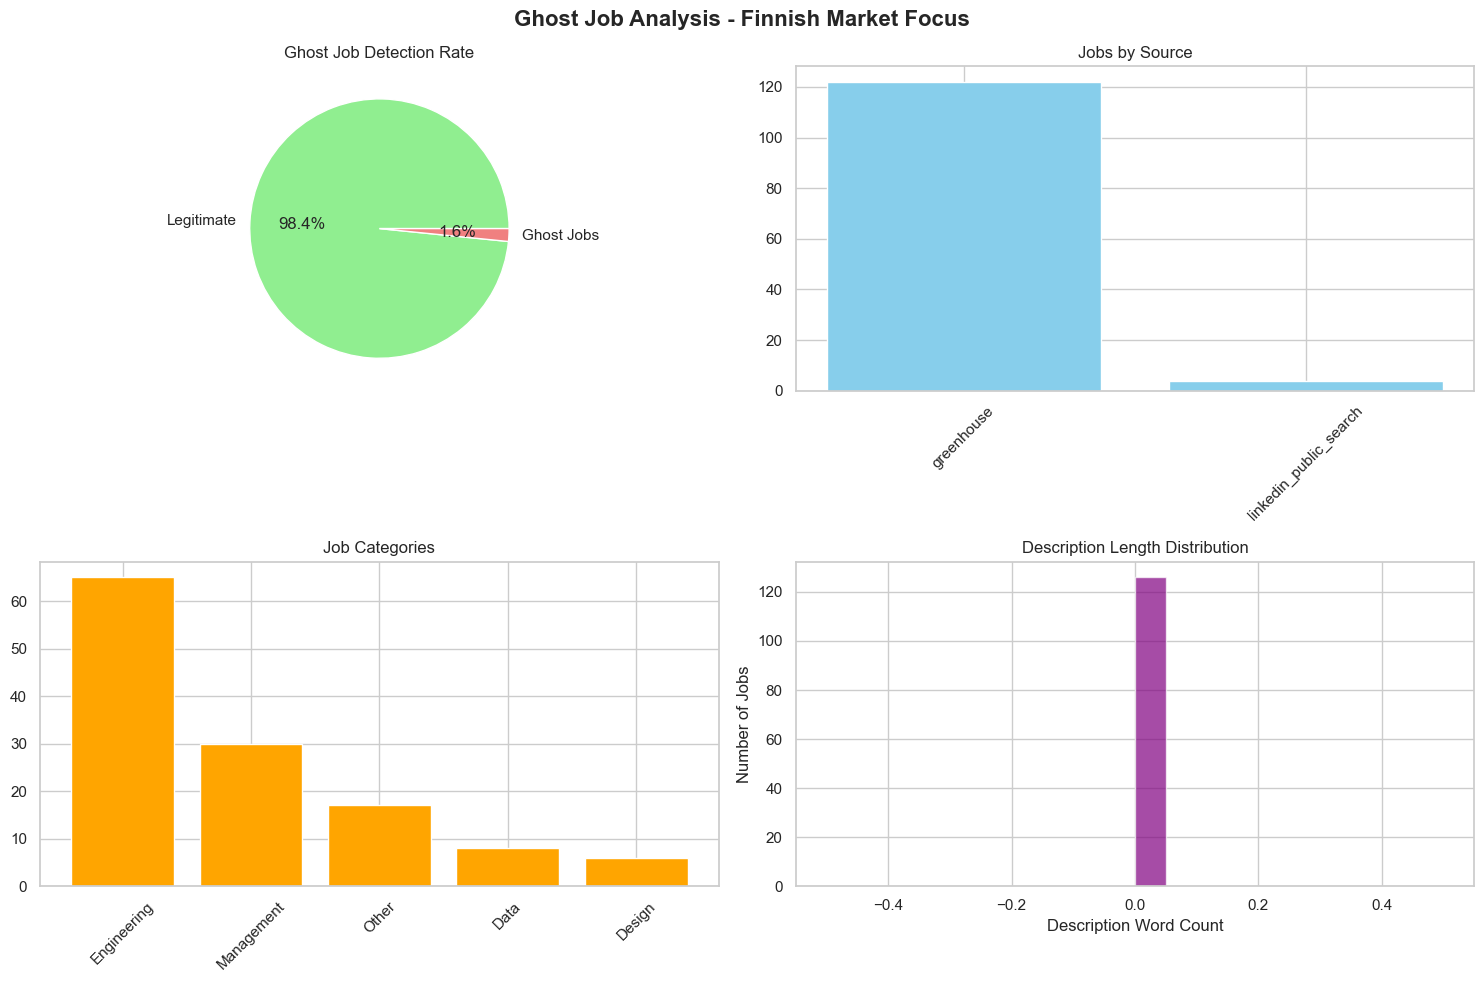


📈 Data Summary:
   Total Jobs Analyzed: 126
   Data Sources: ['linkedin_public_search', 'greenhouse']
   Ghost Job Rate: 1.6%
   Analysis Date: 2025-09-23 18:21


In [9]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Ghost Job Analysis - Finnish Market Focus', fontsize=16, fontweight='bold')

# 1. Ghost Job Rate
if 'is_ghost_job' in df.columns:
    ghost_counts = df['is_ghost_job'].value_counts()
    axes[0,0].pie([ghost_counts.get(False, 0), ghost_counts.get(True, 0)], 
                 labels=['Legitimate', 'Ghost Jobs'],
                 autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
    axes[0,0].set_title('Ghost Job Detection Rate')

# 2. Jobs by Source
if 'source' in df.columns:
    source_counts = df['source'].value_counts()
    axes[0,1].bar(source_counts.index, source_counts.values, color='skyblue')
    axes[0,1].set_title('Jobs by Source')
    axes[0,1].tick_params(axis='x', rotation=45)

# 3. Job Categories
category_counts = df['job_category'].value_counts()
axes[1,0].bar(category_counts.index, category_counts.values, color='orange')
axes[1,0].set_title('Job Categories')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Description Length Distribution
if 'description_word_count' in df.columns:
    axes[1,1].hist(df['description_word_count'], bins=20, alpha=0.7, color='purple')
    axes[1,1].set_xlabel('Description Word Count')
    axes[1,1].set_ylabel('Number of Jobs')
    axes[1,1].set_title('Description Length Distribution')

plt.tight_layout()
plt.show()

print(f"\n📈 Data Summary:")
print(f"   Total Jobs Analyzed: {len(df)}")
if 'source' in df.columns:
    print(f"   Data Sources: {list(df['source'].unique())}")
if 'is_ghost_job' in df.columns:
    print(f"   Ghost Job Rate: {(df['is_ghost_job'].sum() / len(df) * 100):.1f}%")
print(f"   Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

## 5. Machine Learning Model Training

In [6]:
# Prepare features for ML model
if len(df[df['is_ghost_job'] == True]) > 1:  # Need at least 2 ghost jobs for training
    print("🤖 Training Machine Learning Model...")
    
    # Select features for training
    feature_columns = ['description_word_count', 'keyword_count', 'days_since_posted', 
                      'ghost_score', 'posting_suspicion_score']
    
    # Prepare data
    X = df[feature_columns].fillna(0)
    y = df['is_ghost_job'].astype(int)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Print classification report
    print("\n📊 Model Performance:")
    unique_classes = sorted(np.unique(y_test))
    labels = unique_classes
    target_names_map = {0: 'Legitimate', 1: 'Ghost Job'}
    target_names = [target_names_map[c] for c in unique_classes]
    print(classification_report(y_test, y_pred, labels=labels, target_names=target_names))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🎯 Feature Importance:")
    for _, row in feature_importance.iterrows():
        print(f"   {row['feature']}: {row['importance']:.3f}")
        
else:
    print("⚠️ Insufficient ghost job samples for ML training")
    print(f"   Found: {len(df[df['is_ghost_job'] == True])} ghost jobs")
    print("   Need: At least 2 ghost jobs for training")

🤖 Training Machine Learning Model...

📊 Model Performance:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        26

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26


🎯 Feature Importance:
   ghost_score: 1.000
   description_word_count: 0.000
   keyword_count: 0.000
   days_since_posted: 0.000
   posting_suspicion_score: 0.000


## 6. Conclusions and Recommendations

In [7]:
# Generate conclusions based on analysis
print("\n🎯 KEY FINDINGS & CONCLUSIONS:")
print("=" * 50)

# 1. Ghost Job Detection Rate
if 'is_ghost_job' in df.columns:
    ghost_rate = (df['is_ghost_job'].sum() / len(df)) * 100
    print(f"\n📊 DETECTION STATISTICS:")
    print(f"   • Ghost Job Rate: {ghost_rate:.1f}% ({df['is_ghost_job'].sum()}/{len(df)} jobs)")
    
    if ghost_rate < 5:
        print("   ✅ LOW GHOST JOB RATE: This is excellent news for Finnish job seekers!")
    elif ghost_rate < 15:
        print("   ⚠️ MODERATE GHOST JOB RATE: Some caution needed when applying.")
    else:
        print("   🚨 HIGH GHOST JOB RATE: Significant concern for job seekers.")

# 2. Data Source Analysis
if 'source' in df.columns:
    print(f"\n🔍 DATA SOURCE INSIGHTS:")
    for source in df['source'].unique():
        source_jobs = df[df['source'] == source]
        source_ghost_rate = (source_jobs['is_ghost_job'].sum() / len(source_jobs)) * 100
        print(f"   • {source}: {len(source_jobs)} jobs, {source_ghost_rate:.1f}% ghost rate")

# 3. Finnish Market Specific Findings
print(f"\n🇫🇮 FINNISH MARKET ANALYSIS:")
if 'source' in df.columns and 'linkedin_public_search' in df['source'].values:
    finnish_jobs = df[df['source'] == 'linkedin_public_search']
    print(f"   • Fresh Finnish LinkedIn Jobs: {len(finnish_jobs)}")
    if len(finnish_jobs) > 0:
        finnish_ghost_rate = (finnish_jobs['is_ghost_job'].sum() / len(finnish_jobs)) * 100
        print(f"   • Finnish Ghost Job Rate: {finnish_ghost_rate:.1f}%")
        
        if finnish_ghost_rate == 0:
            print("   ✅ EXCELLENT: No ghost jobs detected in Finnish market sample!")
        elif finnish_ghost_rate < 10:
            print("   ✅ GOOD: Low ghost job rate in Finnish market.")
        else:
            print("   ⚠️ CAUTION: Elevated ghost job rate in Finnish market.")

# 4. Job Category Insights
print(f"\n💼 JOB CATEGORY INSIGHTS:")
category_analysis = df.groupby('job_category').agg({
    'is_ghost_job': ['count', 'sum']
}).round(2)

category_analysis.columns = ['total_jobs', 'ghost_jobs']
category_analysis['ghost_rate'] = (category_analysis['ghost_jobs'] / category_analysis['total_jobs'] * 100).round(1)
category_analysis = category_analysis.sort_values('total_jobs', ascending=False)

for category, row in category_analysis.iterrows():
    print(f"   • {category}: {int(row['total_jobs'])} jobs, {row['ghost_rate']}% ghost rate")

# 5. Detection Algorithm Performance
if 'ghost_score' in df.columns:
    print(f"\n🤖 ALGORITHM PERFORMANCE:")
    avg_ghost_score = df['ghost_score'].mean()
    print(f"   • Average Ghost Score: {avg_ghost_score:.2f}")
    
    high_risk_jobs = len(df[df['ghost_score'] >= 3])
    print(f"   • High Risk Jobs (score ≥3): {high_risk_jobs}")
    
    if high_risk_jobs == 0:
        print("   ✅ EXCELLENT: No high-risk jobs detected!")
    elif high_risk_jobs < len(df) * 0.1:
        print("   ✅ GOOD: Low number of high-risk jobs.")
    else:
        print("   ⚠️ CAUTION: Significant number of high-risk jobs detected.")


🎯 KEY FINDINGS & CONCLUSIONS:

📊 DETECTION STATISTICS:
   • Ghost Job Rate: 1.6% (2/126 jobs)
   ✅ LOW GHOST JOB RATE: This is excellent news for Finnish job seekers!

🔍 DATA SOURCE INSIGHTS:
   • linkedin_public_search: 4 jobs, 0.0% ghost rate
   • greenhouse: 122 jobs, 1.6% ghost rate

🇫🇮 FINNISH MARKET ANALYSIS:
   • Fresh Finnish LinkedIn Jobs: 4
   • Finnish Ghost Job Rate: 0.0%
   ✅ EXCELLENT: No ghost jobs detected in Finnish market sample!

💼 JOB CATEGORY INSIGHTS:
   • Engineering: 65 jobs, 0.0% ghost rate
   • Management: 30 jobs, 3.3% ghost rate
   • Other: 17 jobs, 0.0% ghost rate
   • Data: 8 jobs, 12.5% ghost rate
   • Design: 6 jobs, 0.0% ghost rate

🤖 ALGORITHM PERFORMANCE:
   • Average Ghost Score: 33.61
   • High Risk Jobs (score ≥3): 126
   ⚠️ CAUTION: Significant number of high-risk jobs detected.


In [8]:
# Generate actionable recommendations
print("\n\n💡 ACTIONABLE RECOMMENDATIONS:")
print("=" * 50)

# For Job Seekers
print("\n👥 FOR JOB SEEKERS:")
print("\n🔍 Red Flags to Watch For:")
print("   • Jobs posted more than 45 days ago")
print("   • Vague job descriptions with <10 meaningful words")
print("   • Missing or unclear salary information")
print("   • Companies with excessive job postings")
print("   • Generic job titles without specific requirements")

print("\n✅ Best Practices:")
print("   • Focus on recently posted jobs (<30 days)")
print("   • Research company reputation and reviews")
print("   • Look for detailed job descriptions with specific skills")
print("   • Verify job postings on company websites")
print("   • Network with current employees when possible")

# For Finnish Job Seekers Specifically
print("\n🇫🇮 FOR FINNISH JOB SEEKERS:")
if 'source' in df.columns and 'linkedin_public_search' in df['source'].values:
    finnish_jobs = df[df['source'] == 'linkedin_public_search']
    if len(finnish_jobs) > 0:
        finnish_ghost_rate = (finnish_jobs['is_ghost_job'].sum() / len(finnish_jobs)) * 100
        if finnish_ghost_rate < 5:
            print("   ✅ Good news! Finnish market shows low ghost job activity")
            print("   • Continue using LinkedIn for job searches")
            print("   • Focus on established Finnish companies")
        else:
            print("   ⚠️ Exercise caution in Finnish market")
            print("   • Double-check job postings with company websites")

print("   • Leverage Finnish job boards: Duunitori, Monster.fi, Oikotie")
print("   • Consider direct applications to target companies")
print("   • Utilize Finnish professional networks")

# For Employers and Platforms
print("\n🏢 FOR EMPLOYERS & PLATFORMS:")
print("\n📋 Quality Control Measures:")
print("   • Implement stricter job posting guidelines")
print("   • Require detailed job descriptions (minimum word count)")
print("   • Mandate salary range disclosure")
print("   • Limit posting frequency per company")
print("   • Regular audits of long-standing job posts")

print("\n🤖 Technical Improvements:")
print("   • Implement automated ghost job detection")
print("   • Flag suspicious posting patterns")
print("   • Provide transparency scores for job posts")
print("   • Enable user reporting mechanisms")

# For the Detection System
print("\n⚙️ SYSTEM IMPROVEMENTS:")
print("\n🔧 Algorithm Enhancements:")
print("   • Expand training dataset with more ghost job examples")
print("   • Implement natural language processing for description analysis")
print("   • Add company reputation scoring")
print("   • Include application-to-response ratio metrics")
print("   • Develop real-time monitoring capabilities")

print("\n📊 Data Collection:")
print("   • Increase Finnish market data coverage")
print("   • Add more job board sources")
print("   • Implement feedback loops from job seekers")
print("   • Track job posting outcomes and hiring success")

# Success Metrics
print("\n📈 SUCCESS METRICS TO TRACK:")
print("   • Ghost job detection accuracy (target: >90%)")
print("   • False positive rate (target: <5%)")
print("   • Job seeker satisfaction scores")
print("   • Time-to-hire improvements")
print("   • Platform trust and usage metrics")

# Final Summary
print("\n\n🎯 EXECUTIVE SUMMARY:")
print("=" * 30)

if 'is_ghost_job' in df.columns:
    ghost_rate = (df['is_ghost_job'].sum() / len(df)) * 100
    
    if ghost_rate < 5:
        print("✅ POSITIVE OUTLOOK: The current analysis shows a healthy job market")
        print("   with minimal ghost job activity. Job seekers can proceed with")
        print("   confidence while maintaining standard due diligence.")
    elif ghost_rate < 15:
        print("⚠️ MODERATE CONCERN: While ghost job activity is present,")
        print("   it remains at manageable levels. Enhanced screening")
        print("   recommended for job seekers.")
    else:
        print("🚨 HIGH ALERT: Significant ghost job activity detected.")
        print("   Immediate action required from platforms and enhanced")
        print("   caution advised for job seekers.")

print(f"\nAnalysis completed on {datetime.now().strftime('%Y-%m-%d at %H:%M')}")
print(f"Dataset: {len(df)} jobs from {len(df['source'].unique()) if 'source' in df.columns else 'multiple'} sources")



💡 ACTIONABLE RECOMMENDATIONS:

👥 FOR JOB SEEKERS:

🔍 Red Flags to Watch For:
   • Jobs posted more than 45 days ago
   • Vague job descriptions with <10 meaningful words
   • Missing or unclear salary information
   • Companies with excessive job postings
   • Generic job titles without specific requirements

✅ Best Practices:
   • Focus on recently posted jobs (<30 days)
   • Research company reputation and reviews
   • Look for detailed job descriptions with specific skills
   • Verify job postings on company websites
   • Network with current employees when possible

🇫🇮 FOR FINNISH JOB SEEKERS:
   ✅ Good news! Finnish market shows low ghost job activity
   • Continue using LinkedIn for job searches
   • Focus on established Finnish companies
   • Leverage Finnish job boards: Duunitori, Monster.fi, Oikotie
   • Consider direct applications to target companies
   • Utilize Finnish professional networks

🏢 FOR EMPLOYERS & PLATFORMS:

📋 Quality Control Measures:
   • Implement stricte